In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Copy contents from My Drive to "/content" in order to import all scripts.
!cp -r /content/drive/My\ Drive/SC_RL /content

In [ ]:
#rm -rf SC_RL/

In [ ]:
!pip install import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=217117fd3836ae26031a05b892e22487eeb2a8ebf454fe017a7faca7eb59ee15
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
## Import libraries.
import import_ipynb
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
import tensorflow as tf
import tensorflow_probability as tfp
import tqdm
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from typing import Any, List, Sequence, Tuple

from SC_RL.Environments import warehouse_store

importing Jupyter notebook from /content/SC_RL/Environments/warehouse_store.ipynb


In [ ]:
metadata_file = Path(os.getcwd()+"/SC_RL/data/instacart-market-basket-analysis/products_metadata.xlsx")
forecast_data = Path(os.getcwd()+"/SC_RL/data/instacart-market-basket-analysis/scenarios.xlsx")
w = warehouse_store.warehouse_store()
num_products = 10
min_produts = 0
max_products = 20 ## Double check.

In [ ]:
def reward_function(states, actions):
  '''
  Should ensure that inventory is stocked, but at the same time, ensure that
  wastage is minimized.
  1 - (quantity_restocked/total quantity of products)
    - (quantity of expired products/total quantity of products)
  '''
  ## only check quantity portion when it is thrown away.
  p_restocked = np.ndarray.sum(actions)
  q_max = np.ndarray.sum(states[0:num_products,0])
  reward = 1 - (p_restocked+states[num_products,0])/q_max
  return reward

In [ ]:
## Test passing a function as argument here:
# total_reward = w.simulate(metadata_file,forecast_data,reward_function) # Need not initialize; just simulate.
# print(total_reward)

## **Actor-Critic**

In [ ]:
lr_actor = 1e-2
lr_critic = 0.01
episodes = 75
gamma = 0.95

In [ ]:
class Critic(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(20,activation='relu')
    self.d2 = tf.keras.layers.Dense(10,activation='relu')
    self.v = tf.keras.layers.Dense(1, activation = None)

  def call(self, input_data):
    x = self.d1(input_data)
    x = self.d2(x)
    v = self.v(x)
    return v
    

class Actor(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.d1 = tf.keras.layers.Dense(20,activation='relu')
    self.d2 = tf.keras.layers.Dense(10,activation='relu')
    self.a = tf.keras.layers.Dense(num_products,activation='softmax')

  def call(self, input_data):
    x = self.d1(input_data)
    x = self.d2(x)
    a = self.a(x)
    return a

In [ ]:
class Agent():
  def __init__(self, gamma = gamma):
    self.gamma = gamma
    self.a_opt = tf.keras.optimizers.Adam(learning_rate=lr_actor)
    self.c_opt = tf.keras.optimizers.Adam(learning_rate=lr_critic)
    self.actor = Actor()
    self.critic = Critic()

  def act(self,state):
    prob = self.actor(np.array([state]))
    prob = prob.numpy()
    #dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
    # dist = tfp.distributions.Normal(loc=0, scale=1)
    # dist = tfp.distributions.Normal(prob,scale=1)
    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
    action = dist.sample().numpy()
    action = action[0][0:num_products]
    action = np.reshape(action,(num_products,1))
    # out = np.empty((num_products,1))
    # for i in range(action.shape[2]):
    #   out[i,0] = np.ceil(np.amax(action[:,:,i]))
    return action

  def actor_loss(self, prob, action, td):
    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
    log_prob = dist.log_prob(action)
    # print("here")
    log_prob = tf.clip_by_value(log_prob, -1e3, 1e3)
    log_prob = tf.where(tf.math.is_nan(log_prob), 0, log_prob)
    # print("log_prob = ",log_prob)
    td = tf.squeeze(td)
    loss = -log_prob*td
    return loss

  def learn(self, state, action, reward, next_state, done):
    state = np.array([state])
    next_state = np.array([next_state])
    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
      p = self.actor(state, training=True)
      v =  self.critic(state,training=True)
      vn = self.critic(next_state, training=True)
      td = reward + self.gamma*vn*(1-int(done)) - v
      # td = reward + self.gamma*vn - v
      # print("td = ",td)
      a_loss = self.actor_loss(p, action, td)
      # print("actor loss = ",a_loss)
      c_loss = td**2
    grads1 = tape1.gradient(a_loss, self.actor.trainable_variables)
    grads2 = tape2.gradient(c_loss, self.critic.trainable_variables)
    self.a_opt.apply_gradients(zip(grads1, self.actor.trainable_variables))
    self.c_opt.apply_gradients(zip(grads2, self.critic.trainable_variables))
    return a_loss, c_loss

In [ ]:
## Training:
scrl = Agent()
tot_reward_vs_episode = []
for ep in range(episodes):
  total_reward_per_episode = 0
  states = w.reset(metadata_file, forecast_data)
  ## get_demand() returns a pre-determined demand of each product for timestep.
  demand = w.get_demand()
  all_aloss = []
  all_closs = []
  current_timestep = 0
  print("Episode number = ",ep)
  for current_timestep in range(w.simulation_duration):
    ## Sample action according to current policy
    action = scrl.act(states)
    # print("current timestep = ",current_timestep)
    ## Execute action and observe reward & next state from E
    next_state, reward, done = w.step(action,demand,current_timestep,reward_function)
    aloss, closs = scrl.learn(states, action, reward, next_state, done)
    all_aloss.append(aloss)
    all_closs.append(closs)
    # print("reward = ",reward)
    total_reward_per_episode += reward
    next_state = states

  tot_reward_vs_episode.append(total_reward_per_episode)
  '''Plot reward here.'''

Episode number =  0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructo

InvalidArgumentError: ignored

In [ ]:
tot_reward_vs_episode

Text(0, 0.5, 'Accumulated reward in each episode')

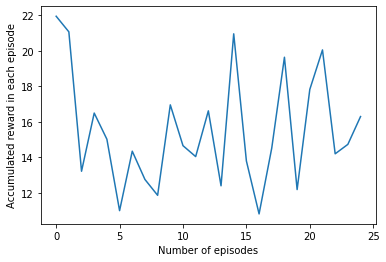

In [ ]:
episode_no = np.arange(episodes)
plt.plot(episode_no,tot_reward_vs_episode)
plt.xlabel("Number of episodes")
plt.ylabel("Accumulated reward in each episode")

Define the Actor-Critic by using a single neural network. The actor will generate the action probabilities, while the critic will evaluate them.

During the forward pass, the model will take in the state as the input and will output both action probabilities and critic value  V , which models the state-dependent value function. The goal is to train a model that chooses actions based on a policy  π  that maximizes expected return.

In [ ]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self, 
      num_actions: int, 
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [ ]:
num_actions = num_products
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

Training the RL-agent using AC involves the following steps:
1. Run the agent on the environment to collect training data per episode.
2. Compute expected return (reward) at each time step.
3. Compute the loss for the combined actor-critic model.
4. Compute gradients and update network parameters.
5. Repeat 1-4 until either success criterion or max episodes (this is used) has been reached.

### 1. Collecting training data

As in supervised learning, in order to train the actor-critic model, we need to have training data. However, in order to collect such data, the model would need to be "run" in the environment.

We collect training data for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

This process is implemented in the run_episode function, which uses TensorFlow operations so that it can later be compiled into a TensorFlow graph for faster training. Note that tf.TensorArrays were used to support Tensor iteration on variable length arrays.

In [ ]:
# Wrap warehouse_environment's `step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, _ = w.step(action)
  return (state.astype(np.float32), 
          np.array(reward, np.int32),
          np.array(done, np.int32))


def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action], 
                           [tf.float32, tf.int32, tf.int32])

In [ ]:
def run_episode(
    initial_state: tf.Tensor,  
    model: tf.keras.Model, 
    max_steps: int) -> List[tf.Tensor]:
  """Runs a single episode to collect training data."""
  
  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  values = dict()
  action_probs = dict()
  rewards = dict()
  for t in tf.range(w.simulation_duration):
    ## Convert state into a batched tensor (batch size = 1)
    # state = tf.expand_dims(state, 0)
    ## Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)
    ## Sample next action from the action probability distribution
    # action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action = tf.random.categorical(action_logits_t, 10)
    print("action = ",action)
    action_probs_t = tf.nn.softmax(action_logits_t)
    print("action_probs_t = ",action_probs_t)
    # Store critic values
    values[t] = value
    # values = values.write(t, tf.squeeze(value))
    # Store log probability of the action chosen
    action_probs[t] = action_probs_t
    # action_probs = action_probs.write(t, action_probs_t[0, action])
    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    ## should be tf_env_step(action,demand,current_timestep,reward_function)
    state.set_shape(initial_state_shape)
  
    # Store reward
    rewards[t] = reward
    # rewards = rewards.write(t, reward)


    if tf.cast(done, tf.bool):
      break

  # action_probs = action_probs.stack()
  # values = values.stack()
  # rewards = rewards.stack()

  return action_probs, values, rewards

### 2. Computing expected returns

We convert the sequence of rewards for each timestep $t$, $\{r_{t}\}^{T}_{t=1}$ collected during one episode into a sequence of expected returns $\{G_{t}\}^{T}_{t=1}$ in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$:

$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$

Since $\gamma\in(0,1)$, rewards further out from the current timestep are given less weight.

Intuitively, expected return simply implies that rewards now are better than rewards later. In a mathematical sense, it is to ensure that the sum of the rewards converges.

To stabilize training, we also standardize the resulting sequence of returns (i.e. to have zero mean and unit standard deviation).

In [ ]:
def get_expected_return(
    rewards: tf.Tensor, 
    gamma: float, 
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) / 
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. The actor-critic loss

Since we are using a hybrid actor-critic model, we will use loss function that is a combination of actor and critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### Actor loss

We formulate the actor loss based on [policy gradients with the critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and compute single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

We add a negative term to the sum since we want to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the critic, it may turn out that there's no advantage ($G - V = 0$) and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

<br>

#### Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


In [ ]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,  
    values: tf.Tensor,  
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. Defining the training step to update parameters

We combine all of the steps above into a training step that is run every episode. All steps leading up to the loss function are executed with the `tf.GradientTape` context to enable automatic differentiation.

We use the Adam optimizer to apply the gradients to the model parameters.

We also compute the sum of the undiscounted rewards, `episode_reward`, in this step which would be used later on to evaluate if we have met the success criterion.

We apply the `tf.function` context to the `train_step` function so that it can be compiled into a callable TensorFlow graph, which can lead to 10x speedup in training.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor, 
    model: tf.keras.Model, 
    optimizer: tf.keras.optimizers.Optimizer, 
    gamma: float, 
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode) 
    print("Run episode of train step.")

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]] 

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. Run the training loop

We execute training by run the training step until either the success criterion or maximum number of episodes is reached.  

We keep a running record of episode rewards using a queue. Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency. 

Depending on your runtime, training can finish in less than a minute.

In [ ]:
%%time

max_episodes = 2
max_steps_per_episode = w.simulation_duration

# Cartpole-v0 is considered solved if average reward is >= 195 over 100 
# consecutive trials
# reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

with tqdm.trange(max_episodes) as t:
  for i in t:
    # initial_state = tf.constant(env.reset(), dtype=tf.float32)
    initial_state = tf.constant(w.reset(metadata_file, forecast_data), dtype=tf.int32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))

    # running_reward = episode_reward*0.01 + running_reward*.99
    running_reward += episode_reward
    t.set_description(f'Episode {i}')
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)
  
    # Show average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')
  
    # if running_reward > reward_threshold:  
    #     break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')